### The second stage of training after `Train DeBERTa-v3-base on pseudo-labeled data`
Finetuning on `bigcode/pii-for-code-v2`

In [2]:
from datasets import load_dataset, load_metric, Dataset, DatasetDict, load_from_disk
from huggingface_hub import notebook_login
import json
import numpy as np
import pandas as pd

In [3]:
notebook_login()

In [3]:
FOLD = 0

model_checkpoint = "microsoft/deberta-v3-base"
batch_size = 16

In [4]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DebertaV2TokenizerFast

from utils import LABEL2ID, ID2LABEL


model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(ID2LABEL))
tokenizer = DebertaV2TokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)

model.config.id2label = {str(i):label for i, label in enumerate(ID2LABEL)}
model.config.label2id = LABEL2ID

tokenizer.model_max_length = 512

/home/monty/projects/pii-ner/utils/misc.py:38: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  _seqeval_metric = load_metric("seqeval")
Using the latest cached version of the module from /home/monty/.cache/huggingface/modules/datasets_modules/metrics/seqeval/c8563af43bdce095d0f9e8b8b79c9c96d5ea5499b3bf66f90301c9cb82910f11 (last modified on Thu Feb 16 17:58:29 2023) since it couldn't be found locally at seqeval, or remotely on the Hugging Face Hub.
Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2ForTokenClassification: ['lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'deberta.embeddings.position_embeddings.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bi

In [5]:
model = AutoModelForTokenClassification.from_pretrained('deberta-v3-base-pretrained/checkpoint-3000')

In [6]:
dataset = dev_dataset = load_dataset("bigcode/pii-for-code-v2/", use_auth_token=True)['train']

In [7]:
from utils import label_tokenized, chunk_dataset

def tokenize_and_label(entry, tokenizer=tokenizer):
    inputs = tokenizer.encode_plus(entry['content'], return_offsets_mapping=True, add_special_tokens=False)
    entry.update(inputs)
    return label_tokenized(entry)

dataset = dataset.map(lambda x: dict(pii=json.loads(x['pii'])))
dataset = dataset.map(tokenize_and_label)

dataset =  DatasetDict(
    train = dataset.filter(lambda x: x['fold']!=FOLD),
    dev = dataset.filter(lambda x: x['fold']==FOLD)
)
dataset

Loading cached processed dataset at /data3/monty/datasets/pii-for-code-folds/train/cache-508fbacd9f7bdf6a.arrow
Loading cached processed dataset at /data3/monty/datasets/pii-for-code-folds/train/cache-a8ea847edbdece61.arrow
Loading cached processed dataset at /data3/monty/datasets/pii-for-code-folds/train/cache-3686d4caf026edda.arrow
Loading cached processed dataset at /data3/monty/datasets/pii-for-code-folds/train/cache-1174fa42815e03f0.arrow


DatasetDict({
    train: Dataset({
        features: ['content', 'language', 'license', 'path', 'annotation_id', 'pii', 'id', 'fold', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 300
    })
    dev: Dataset({
        features: ['content', 'language', 'license', 'path', 'annotation_id', 'pii', 'id', 'fold', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 100
    })
})

In [8]:
ner_dataset = DatasetDict(
    train = chunk_dataset(dataset['train'], tokenizer),
    validation = chunk_dataset(dataset['dev'], tokenizer),
    test = chunk_dataset(dataset['dev'], tokenizer, overlap_freq=2),
)
ner_dataset

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'id', 'chunk_id'],
        num_rows: 1527
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'id', 'chunk_id'],
        num_rows: 513
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels', 'id', 'chunk_id'],
        num_rows: 966
    })
})

## Training

In [14]:
from transformers import DataCollatorForTokenClassification, EarlyStoppingCallback

data_collator = DataCollatorForTokenClassification(tokenizer)
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned",
    overwrite_output_dir=True,
    evaluation_strategy = "steps",
    save_strategy='steps',
    num_train_epochs=100,
    eval_steps=300,
    save_steps=300,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    metric_for_best_model="f1",
    load_best_model_at_end = True,
    weight_decay=0.01,
    logging_steps=10,
    save_total_limit=30,
    push_to_hub=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [15]:
from utils import compute_metrics

trainer = Trainer(
    model,
    args,
    train_dataset=ner_dataset["train"],
    eval_dataset=ner_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience = 30, early_stopping_threshold= 1e-3)]
)

In [18]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForTokenClassification.forward` and have been ignored: chunk_id, id. If chunk_id, id are not expected by `DebertaV2ForTokenClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 1527
  Num Epochs = 100
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 9600


Step,Training Loss,Validation Loss,Avg.precision,Precision,Recall,F1,Email,Ip Address,Key,Name,Password,Username
300,0.001400,0.010239,0.906294,0.550432,0.620130,0.583206,0.950495,0.466667,0.352941,0.793651,0.862745,0.360000
600,0.000600,0.012467,0.869234,0.561350,0.594156,0.577287,0.950495,0.531250,0.375000,0.816667,0.846154,0.313167
900,0.000700,0.013248,0.872781,0.523121,0.587662,0.553517,0.941176,0.551724,0.352941,0.776860,0.867925,0.290429
1200,0.001300,0.013298,0.862504,0.728000,0.590909,0.652330,0.970297,0.705882,0.454545,0.765217,0.862745,0.403670
1500,0.000300,0.014682,0.863409,0.646853,0.600649,0.622896,0.941176,0.857143,0.285714,0.803279,0.884615,0.347826
1800,0.000700,0.010992,0.891844,0.687500,0.785714,0.733333,0.950495,0.878049,0.352941,0.816667,0.814815,0.627692
2100,0.000100,0.015342,0.854070,0.553191,0.590909,0.571429,0.824561,0.679245,0.333333,0.796610,0.901961,0.313167
2400,0.000200,0.019116,0.849698,0.609428,0.587662,0.598347,0.941176,0.705882,0.428571,0.803419,0.862745,0.320896
2700,0.000200,0.021797,0.831837,0.669231,0.564935,0.612676,0.941176,0.631579,0.428571,0.747826,0.862745,0.352423
3000,0.000600,0.019296,0.848694,0.565625,0.587662,0.576433,0.941176,0.507042,0.375000,0.789916,0.862745,0.324528


The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForTokenClassification.forward` and have been ignored: chunk_id, id. If chunk_id, id are not expected by `DebertaV2ForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 513
  Batch size = 16
Saving model checkpoint to /data3/monty/deberta-v3-base-finetuned-test-run/checkpoint-300
Configuration saved in /data3/monty/deberta-v3-base-finetuned-test-run/checkpoint-300/config.json
Model weights saved in /data3/monty/deberta-v3-base-finetuned-test-run/checkpoint-300/pytorch_model.bin
tokenizer config file saved in /data3/monty/deberta-v3-base-finetuned-test-run/checkpoint-300/tokenizer_config.json
Special tokens file saved in /data3/monty/deberta-v3-base-finetuned-test-run/checkpoint-300/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForTokenClassification.forward` and

TrainOutput(global_step=9600, training_loss=0.0004251273045599646, metrics={'train_runtime': 7868.4968, 'train_samples_per_second': 19.407, 'train_steps_per_second': 1.22, 'total_flos': 4.006130538500283e+16, 'train_loss': 0.0004251273045599646, 'epoch': 100.0})

## Evaluation

In [19]:
pred = trainer.predict(ner_dataset['test'])

The following columns in the test set don't have a corresponding argument in `DebertaV2ForTokenClassification.forward` and have been ignored: chunk_id, id. If chunk_id, id are not expected by `DebertaV2ForTokenClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 966
  Batch size = 16


/data1/monty/miniconda3/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
from utils.chunking import compose_chunk_predictions_with_samples

dev_dataset = compose_chunk_predictions_with_samples(dataset['dev'], pred, ner_dataset['test']['id'], tokenizer)

  0%|          | 0/100 [00:00<?, ?ex/s]

In [21]:
dev_dataset

Dataset({
    features: ['content', 'language', 'license', 'path', 'annotation_id', 'pii', 'id', 'fold', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'pred'],
    num_rows: 100
})

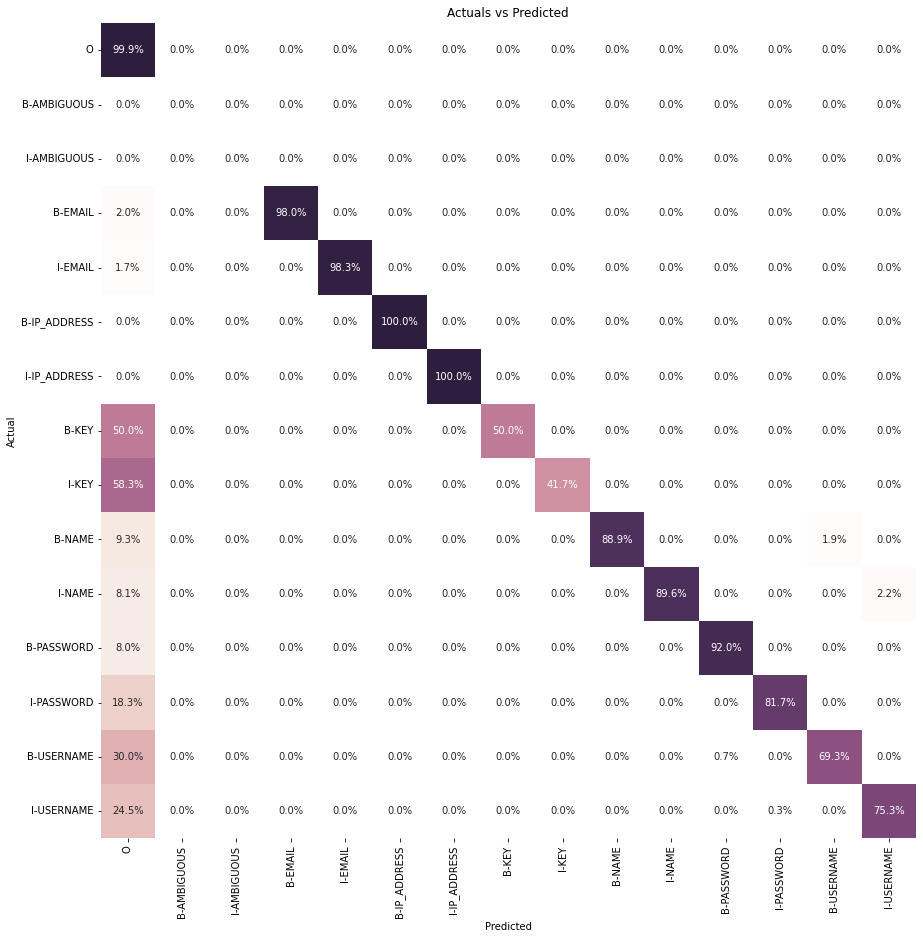

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

true_labels = np.array(list(itertools.chain(*dev_dataset['labels'])))
pred_labels = np.argmax(list(itertools.chain(*dev_dataset['pred'])), axis=-1)

data = confusion_matrix(true_labels, pred_labels, labels=range(len(ID2LABEL)), normalize = 'true')
df_cm = pd.DataFrame(data, columns=ID2LABEL, index = ID2LABEL)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'


f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.1%',
            annot_kws={'size': 10})
plt.title('Actuals vs Predicted')
plt.show()

In [30]:
dev_dataset = compose_chunk_predictions_with_samples(dataset['dev'], pred, ner_dataset['test']['id'], tokenizer)

Loading cached processed dataset at /data3/monty/datasets/pii-for-code-folds/train/cache-0332dd98b41f0387.arrow


In [23]:
from utils.postprocessing import retokenize_with_logits


The `retokenize_with_logits` function re-tokenizes the `content` by RegexpTokenizer and aggregates `pred` logits for tokens which had been merged.

__Example:__

Let for next string:

    content = "\
    # Created by Big Koddy McModel <bigkoddy@examplemail.com>
    'SUPER_SECRET_KEY':'1234LjlkdslfKSLJ'"

we have next tokenization and logits:

     #| Created| by| Big| Ko|ddy| Mc|Model| <|big|ko|ddy|@|example|mail|.|com|> ... | - tokens
     [    0    , 0 , 0.9, .8, .9, 1., 0.97, 0, .8,.9,.9,.9, 0.89  , 1. ,1.,1.,0 ... ] - logits


 then `retokenize_with_logits` transforms it into next:
 
     #| Created| by| Big| Koddy| McModel| <|bigkoddy|@|examplemail.com|>|'|SUPER_SECRET_KEY|'|:|'|1234LjlkdslfKSL|'
     [      0 ,  0, 0.9,  0.95,    0.98, 0,   0.99, .9,   0.9        , 0,0,        0       ,0,0,0,       0.98     ]
     



In [24]:
dev_dataset = dev_dataset.map(lambda x: retokenize_with_logits(**x)).map(label_tokenized)

  0%|          | 0/100 [00:00<?, ?ex/s]

  0%|          | 0/100 [00:00<?, ?ex/s]

In [25]:
dev_dataset = dev_dataset.map(lambda x: dict(
    pred_labels=[ID2LABEL[np.argmax(pred, axis=-1)] for pred in x['pred']],
    true_labels=[ID2LABEL[label] for label in x['labels']]
))

  0%|          | 0/100 [00:00<?, ?ex/s]

In [26]:
from datasets import load_metric
seqeval_metric = load_metric("seqeval")
ner_metrics = seqeval_metric.compute(predictions=dev_dataset['pred_labels'], references=dev_dataset['true_labels'])

Using the latest cached version of the module from /home/monty/.cache/huggingface/modules/datasets_modules/metrics/seqeval/c8563af43bdce095d0f9e8b8b79c9c96d5ea5499b3bf66f90301c9cb82910f11 (last modified on Thu Feb 16 17:58:29 2023) since it couldn't be found locally at seqeval, or remotely on the Hugging Face Hub.
/data1/monty/miniconda3/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
per_type_metrics = pd.DataFrame.from_dict(
    {key:val for key,val in ner_metrics.items()
     if key not in ['overall_precision','overall_recall','overall_f1','overall_accuracy']}
).T
per_type_metrics['number'] = per_type_metrics['number'].astype(int)
per_type_metrics.style.format({'precision': '{:.1%}', 'recall': '{:.1%}','f1': '{:.1%}'})

,precision,recall,f1,number
AMBIGUOUS,0.0%,0.0%,0.0%,0
EMAIL,96.1%,96.1%,96.1%,51
IP_ADDRESS,85.7%,100.0%,92.3%,18
KEY,42.9%,37.5%,40.0%,8
NAME,88.7%,87.0%,87.9%,54
PASSWORD,80.0%,80.0%,80.0%,25
USERNAME,86.0%,69.3%,76.8%,150


In [29]:
pd.Series(
    {key:val for key,val in ner_metrics.items()
     if key  in ['overall_precision','overall_recall','overall_f1','overall_accuracy']}
).T.rename('metric').to_frame().style.format('{:.1%}')

,metric
overall_precision,86.1%
overall_recall,78.8%
overall_f1,82.3%
overall_accuracy,99.8%
